<a href="https://colab.research.google.com/github/clwilkinson7/Temp/blob/main/Week_12_DL7_3_pretrain_Weekly_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leveraging a pretrained model

### Feature extraction with a pretrained model

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Facial Recognition Dataset.zip to Facial Recognition Dataset.zip


In [33]:
try:
  !rm -rf Facial\ Recognition\ Dataset
except:
  pass

!unzip -q Facial\ Recognition\ Dataset.zip

In [34]:
try:
  !rm -rf Dataset
except:
  pass

!mkdir -p Dataset/Train/PersonA Dataset/Train/PersonB Dataset/Train/PersonC
!mkdir -p Dataset/Validation/PersonA Dataset/Validation/PersonB Dataset/Validation/PersonC
!mkdir -p Dataset/Test/PersonA Dataset/Test/PersonB Dataset/Test/PersonC

In [35]:
import os
import cv2


imagePaths = []
imageLabels = []
dataset = "Facial Recognition Dataset"


for label in os.listdir(dataset):
  labelPath = os.path.join(dataset, label)
  for image in os.listdir(labelPath):
    imagePath = os.path.join(labelPath, image)
    if image.endswith(".JPG"):
      newImagePath = imagePath[:-4] + ".jpg"
      os.rename(imagePath, newImagePath)
      imagePath = newImagePath

    imagePaths.append(imagePath)
    imageLabels.append(label)

In [36]:
from sklearn.model_selection import train_test_split

trainDataset, tempDataset, trainLabels, tempLabels = train_test_split(imagePaths, imageLabels, test_size=0.4, random_state=42, stratify=imageLabels)
validationDataset, testDataset, validationLabels, testLabels = train_test_split(tempDataset, tempLabels, test_size=0.5, random_state=42, stratify=tempLabels)

In [37]:
import shutil
from pathlib import Path

trainDir = Path("Dataset/Train/")
validationDir = Path("Dataset/Validation/")
testDir = Path("Dataset/Test/")

trainDirs = [str(dir) for dir in trainDir.iterdir() if dir.is_dir()]
validationDirs = [str(dir) for dir in validationDir.iterdir() if dir.is_dir()]
testDirs = [str(dir) for dir in testDir.iterdir() if dir.is_dir()]

for path in trainDataset:
  label = os.path.basename(os.path.dirname(path))
  for dir in trainDirs:
    if label == os.path.basename(dir):
      shutil.copy(path, dir)

for path in validationDataset:
  label = os.path.basename(os.path.dirname(path))
  for dir in validationDirs:
    if label == os.path.basename(dir):
      shutil.copy(path, dir)

for path in testDataset:
  label = os.path.basename(os.path.dirname(path))
  for dir in testDirs:
    if label == os.path.basename(dir):
      shutil.copy(path, dir)

In [38]:
from tensorflow.keras.utils import image_dataset_from_directory

imageSize = (180, 180)
batchSize = 8

trainDatasetBatched = image_dataset_from_directory(
    trainDir,
    image_size = imageSize,
    batch_size = batchSize,
)

validationDatasetBatched = image_dataset_from_directory(
    validationDir,
    image_size=imageSize,
    batch_size = batchSize,
)

testDatasetBatched = image_dataset_from_directory(
    testDir,
    image_size = imageSize,
    batch_size=batchSize,
)

Found 144 files belonging to 3 classes.
Found 48 files belonging to 3 classes.
Found 48 files belonging to 3 classes.


**Instantiating the VGG16 convolutional base**

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [41]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(trainDatasetBatched)
val_features, val_labels =  get_features_and_labels(validationDatasetBatched)
test_features, test_labels =  get_features_and_labels(testDatasetBatched)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [42]:
train_features.shape

(144, 5, 5, 512)

Defining and training the densely connected classifier

In [43]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.4323 - loss: -23.1687 - val_accuracy: 0.5417 - val_loss: -171.1641
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5346 - loss: -242.8453 - val_accuracy: 0.4167 - val_loss: -326.2566
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4936 - loss: -411.4323 - val_accuracy: 0.4167 - val_loss: -471.7383
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4744 - loss: -719.6407 - val_accuracy: 0.4583 - val_loss: -622.0446
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5221 - loss: -961.1774 - val_accuracy: 0.4583 - val_loss: -766.2568
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5448 - loss: -1118.6499 - val_accuracy: 0.4583 - val_loss: -943.0764
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4741 - loss: -1586.0107 - val_accuracy: 0.4583 - val_loss: -1111.7330
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5712 - loss: -147

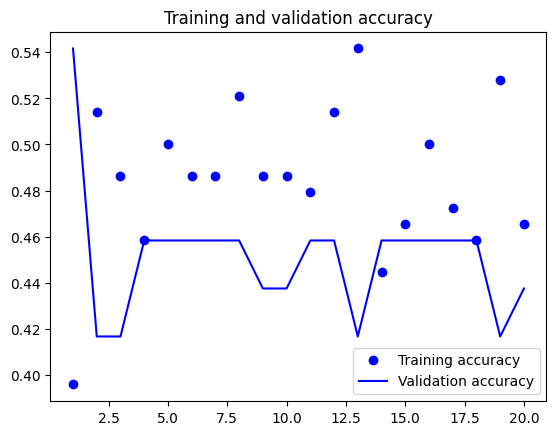

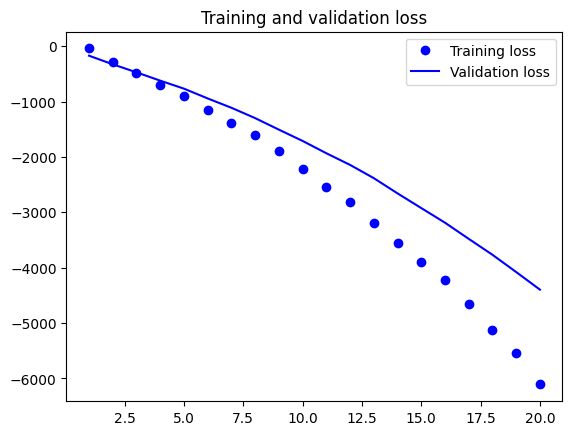

In [44]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [45]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [46]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [47]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [48]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [49]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │      3,277,056 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [50]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    trainDatasetBatched,
    epochs=50,
    validation_data=validationDatasetBatched,
    callbacks=callbacks)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.3872 - loss: -30.4994 - val_accuracy: 0.3750 - val_loss: -236.2110
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4624 - loss: -208.1236 - val_accuracy: 0.4792 - val_loss: -453.8332
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4834 - loss: -318.5832 - val_accuracy: 0.4583 - val_loss: -688.5916
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4591 - loss: -547.1615 - val_accuracy: 0.3958 - val_loss: -992.4113
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4371 - loss: -1044.6732 - val_accuracy: 0.4583 - val_loss: -1379.5459
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.4139 - loss: -1121.4485 - val_accuracy: 0.4167 - val_loss: -1736.5062
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4360 - loss: -1425.3381 - val_accuracy: 0.4167 - val_loss: -2165.4722
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - acc

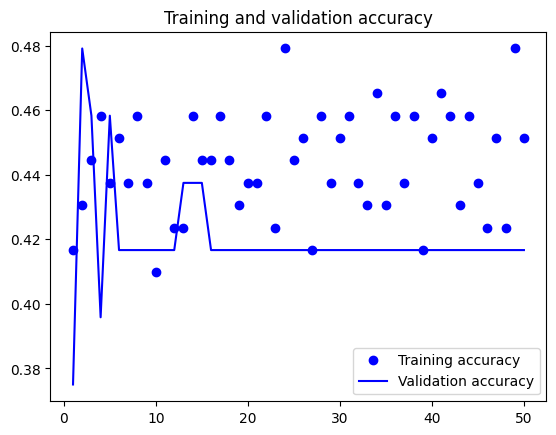

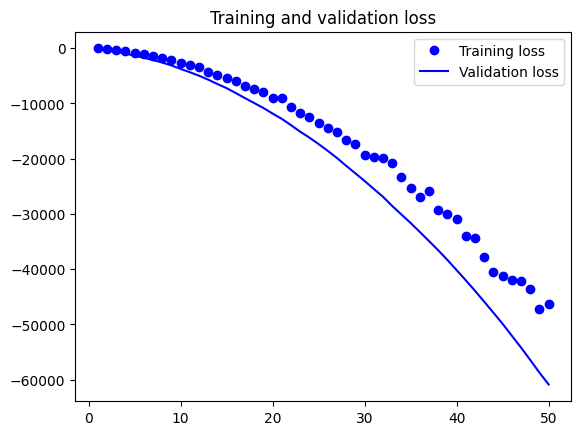

In [51]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [52]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(testDatasetBatched)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4068 - loss: -59461.9492
Test accuracy: 0.417


### Fine-tuning a pretrained model

In [53]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

**Freezing all layers until the fourth from the last**

In [54]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [55]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Fine-tuning the model**

In [56]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    trainDatasetBatched,
    epochs=30,
    validation_data=validationDatasetBatched,
    callbacks=callbacks)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.3792 - loss: -84652.0938 - val_accuracy: 0.4583 - val_loss: -202646.1875
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.3955 - loss: -201861.4062 - val_accuracy: 0.3958 - val_loss: -370287.2500
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4608 - loss: -290362.9375 - val_accuracy: 0.3542 - val_loss: -591315.8750
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.4599 - loss: -401028.0000 - val_accuracy: 0.4167 - val_loss: -852746.5000
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.4183 - loss: -743692.6250 - val_accuracy: 0.3750 - val_loss: -1160130.5000
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5148 - loss: -782097.2500 - val_accuracy: 0.3750 - val_loss: -1460167.6250
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4060 - loss: -1166289.3750 - val_accuracy: 0.3958 - val_loss: -1824787.6250
Epoch 8/30
18/18 

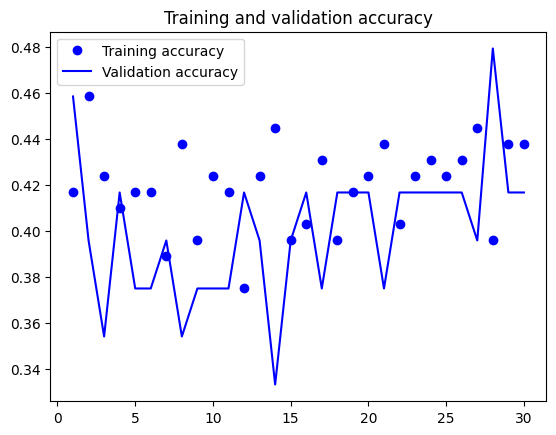

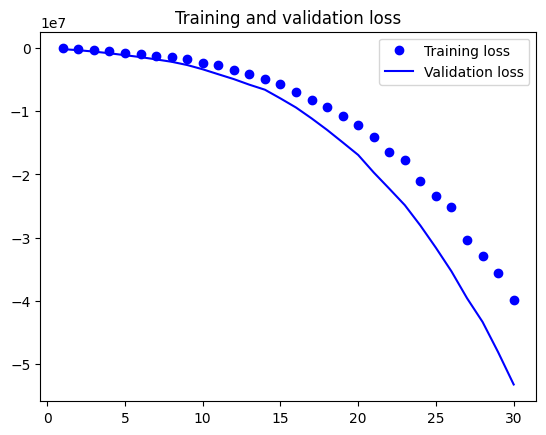

In [57]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [58]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(testDatasetBatched)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4193 - loss: -47740984.0000
Test accuracy: 0.417
